## Training of the neural network for the X-ray reconstruction

In the following notebook, an hexsample simulation will be extracted, preprocessed and used for training a neural network for inferring the X-ray energy and its hit position.

In [1]:
import os

import numpy as np

from IPython import display

# importing the necessary keras modules for model creation, training and saving
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential
from matplotlib import pyplot as plt

In [14]:
# importing the custom libraries
from xrayreco.preprocessing import Xraydata
from hexsample.fileio import ReconInputFile, DigiInputFileCircular

### Data preprocessing and preliminary visualization
In the following, we will use a simulation where the electronic noise of every pixel is set to zero. The `.h5` file will be opened, the inuput and target data for the NNs will be extracted and the distribution visualized. 

In [3]:
# Loading an hexsample simulation and storing its content into an Xraydata object
# The following simulation is a simulation with no electronic noise.
file_path = '/Users/chiara/hexsampledata/hxsim_0ENC.h5'
# Creating an istance of the class Xraydata that contains the data preprocessing methods
data = Xraydata(file_path)

>>> Opening input file /Users/chiara/hexsampledata/hxsim_0ENC.h5...
>>> File type: FileType.DIGI


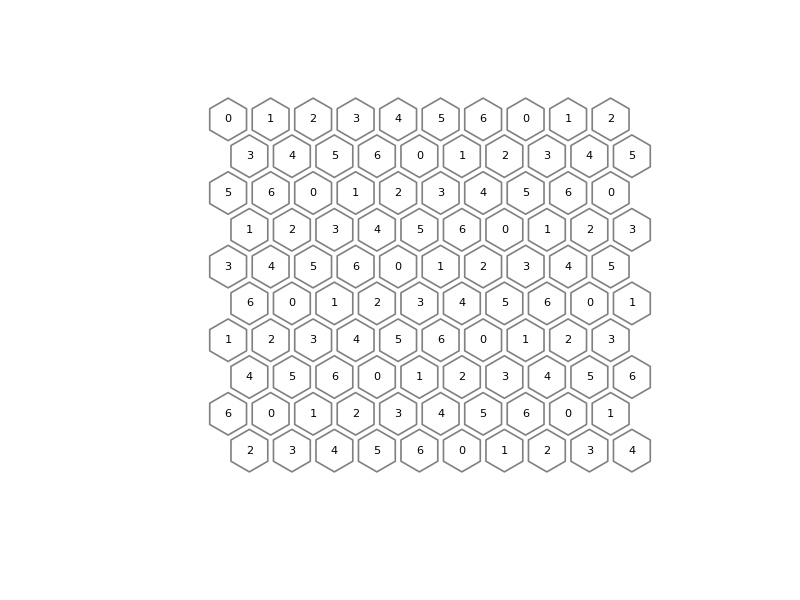

In [4]:
# Showing the hexagonal grid for reference
display.Image("Hexagonal_routing_7_HexagonalLayout.ODD_R.png")

This disposition of the hexagonal grid is labelled as `ODD_R` (see https://www.redblobgames.com/grids/hexagons/#coordinates-offset). 

In [5]:
# The Xraydata object contains methods for preprocessing that give the input and training output for the NN
input_data = data.input_events_data()
# Obtaining training output data from MC truth
target_data = data.target_data()

0it [00:00, ?it/s]

1000000it [00:34, 29283.50it/s]


In [6]:
# When data are no more needed, we can close the datafile
data.close_input_file()

In [7]:
# Printing the input data of the first event and the shape of the overall input array
print(f'Event 0: {input_data[0]}')
print(f'Input data shape: {input_data.shape}')

Event 0: [[ 2.18500000e+03  2.25000000e-02 -7.79422863e-03]
 [ 0.00000000e+00  2.55000000e-02 -2.59807621e-03]
 [ 0.00000000e+00  2.85000000e-02 -7.79422863e-03]
 [ 0.00000000e+00  2.55000000e-02 -1.29903811e-02]
 [ 0.00000000e+00  1.95000000e-02 -1.29903811e-02]
 [ 0.00000000e+00  1.65000000e-02 -7.79422863e-03]
 [ 0.00000000e+00  1.95000000e-02 -2.59807621e-03]]
Input data shape: (1000000, 7, 3)


As we can see, the input data is a numpy array of shape (n, 7, 3), where:
- n is the number of simulated events;
- 7 is the number of pixels of every event track;
- 3 is the number of informations contained in every pixel: (pha, x, y).  

In [6]:
# Printing the target array of the first event and the shape of the overall target array
print(f'Energy = {target_data[0][0]}')
print(f'Hit coordinates: ({target_data[0][1:]})')
print(f'Target data shape: {target_data.shape}')

Energy = 8026.7001953125
Hit coordinates: ([-0.00012503 -0.0001334 ])
Target data shape: (1000000, 3)


Energy array [8026.70019531 8046.29980469 8026.70019531 ... 8046.29980469 8901.70019531
 8903.90039062]


Text(0.5, 0, 'Photon energy [eV]')

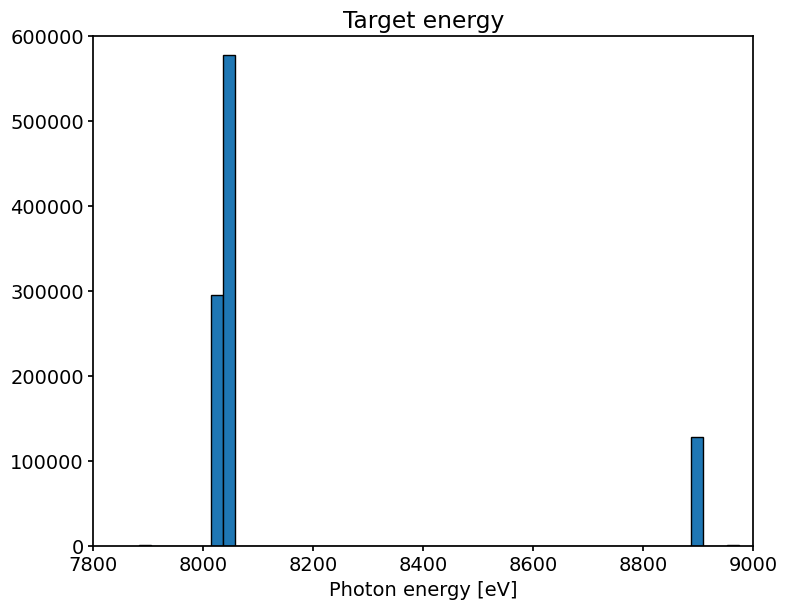

In [7]:
#Printing the energy array and plotting the energy distribution
print(f'Energy array {target_data[:,0]}')
plt.title('Target energy')
plt.hist(target_data[:,0], bins=50)
plt.xlabel('Photon energy [eV]')

Text(0.5, 0, 'x displacement from the center of the central signal pixel [cm]')

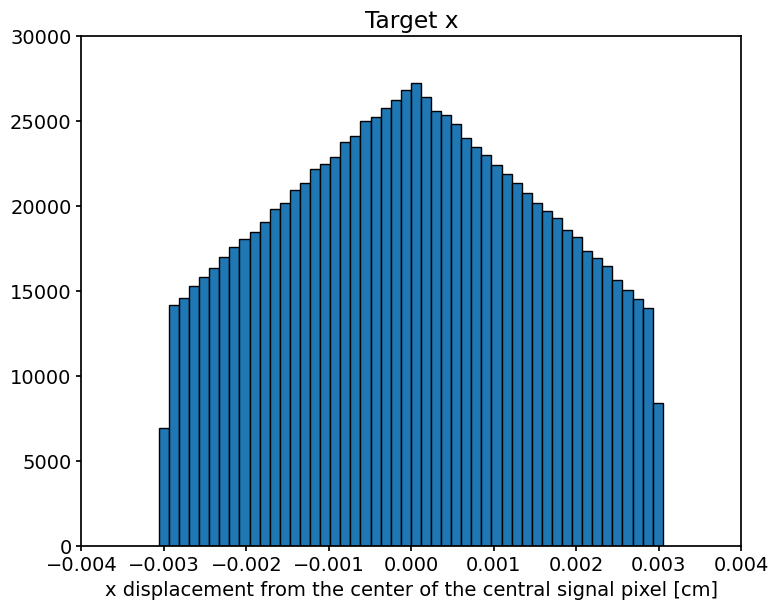

In [8]:
# Doing the same for the hit coordinates
# Plotting the histogram of the x-hit coordinates
plt.title('Target x')
plt.hist(target_data[:,1], bins=50)
plt.xlabel('x displacement from the center of the central signal pixel [cm]')

Text(0.5, 0, 'y displacement from the center of the central signal pixel [cm]')

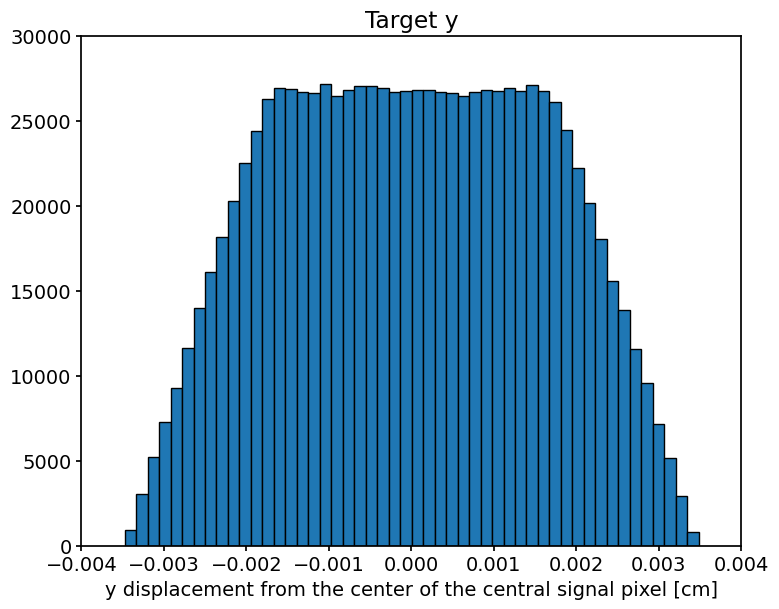

In [9]:
# Doing the same for the hit coordinates
# Plotting the histogram of the y-hit coordinates
plt.title('Target y')
plt.hist(target_data[:,2], bins=50)
plt.xlabel('y displacement from the center of the central signal pixel [cm]')

### Neural Network definition and training
#### Neural Network for energy regression

In [12]:
# Creating the FFNN models. One for energy regression, one for position regression

# define NN model, compile and train
model_e = Sequential([
                    Flatten(input_shape=(7,3)),
                    BatchNormalization(),
                    Dense(64, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(1, activation='linear')
                    ])

model_e.compile(optimizer='adam',
                  loss='MSE',
                  metrics=['accuracy'])

model_e.summary()


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21)             │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,397 (239.83 KB)

 Trainable params: 61,355 (239.67 KB)

 Non-trainable params: 42 (168.00 B)

In [24]:
# Loading the last model weights if already trained at least once
checkpoint_path = "training_1/cp_e.weights.h5"
model_e.load_weights(checkpoint_path)


In [25]:
# Defining the path and directory for checkpoints that save the model's weights.
checkpoint_path = "training_1/cp_e.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

#Training the NN for energy regression
history_e = model_e.fit(input_data, target_data[:,0], validation_split=0.05, epochs=50, callbacks=[cp_callback])
#done by now 150 epochs

Epoch 1/50
29634/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.0000e+00 - loss: 34849.2773
Epoch 1: saving model to training_1/cp_e.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 26s 874us/step - accuracy: 0.0000e+00 - loss: 34849.0156 - val_accuracy: 0.0000e+00 - val_loss: 26014.8145
Epoch 2/50
29666/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.0000e+00 - loss: 34855.2734
Epoch 2: saving model to training_1/cp_e.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 25s 851us/step - accuracy: 0.0000e+00 - loss: 34855.2500 - val_accuracy: 0.0000e+00 - val_loss: 25305.4160
Epoch 3/50
29629/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.0000e+00 - loss: 34701.4336
Epoch 3: saving model to training_1/cp_e.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 25s 825us/step - accuracy: 0.0000e+00 - loss: 34701.4883 - val_accuracy: 0.0000e+00 - val_loss: 26558.2754
Epoch 4/50
29673/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.0000e+00 - loss: 34738.8516
Epoch 4: saving model to

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


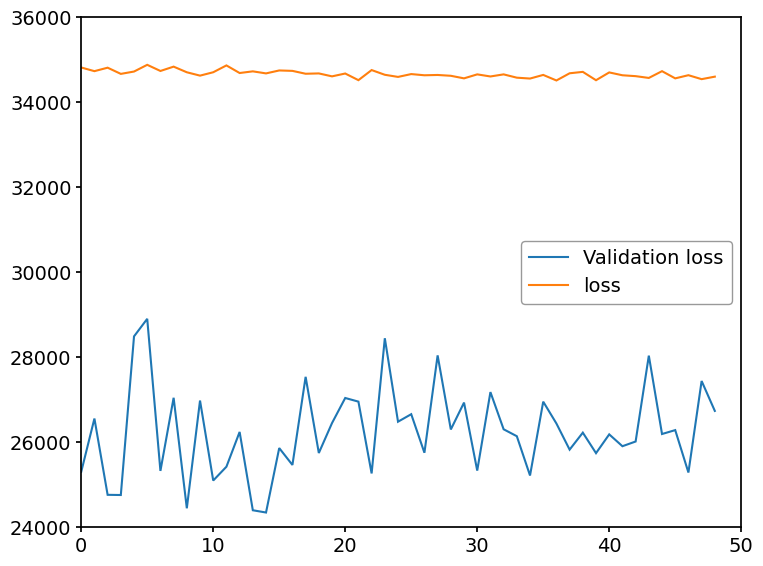

In [26]:
print(history_e.history.keys())
plt.plot(history_e.history['val_loss'][1:], label='Validation loss')
plt.plot(history_e.history['loss'][1:], label='loss')
plt.legend()
plt.show()

This is weird.. []

After the training, we want to compare the performance of the NN wrt the target data and wrt the standard reconstruction analysis. We will use as training data another simulation with the same parameters as the training one, reconstruct that and compare the interesting metrics.  
For the energy, the interesting metrics are:
- the energy shifts from the real values;
- the energy resolutions.


In [3]:
# Opening the test data file
test_data = Xraydata('/Users/chiara/hexsampledata/sim_HexagonalLayout.ODD_Rum_0enc_srcsigma200um.h5')

>>> Opening input file /Users/chiara/hexsampledata/sim_HexagonalLayout.ODD_Rum_0enc_srcsigma200um.h5...
>>> File type: FileType.DIGI


In [23]:
# Opening the reconstructed file relative to the test data
recon_file = ReconInputFile('/Users/chiara/hexsampledata/sim_HexagonalLayout.ODD_Rum_0enc_srcsigma200um_recon.h5')

>>> Opening input file /Users/chiara/hexsampledata/sim_HexagonalLayout.ODD_Rum_0enc_srcsigma200um_recon.h5...
>>> File type: FileType.RECON


In [24]:
# Obtaining the reconstructed energy
recon_energies = recon_file.column('energy')
recon_x = recon_file.column('posx')
recon_y = recon_file.column('posy')

In [20]:
# Extrapolating input data and predicting the target using the NN
test_input_data = test_data.input_events_data()
test_target_data = test_data.target_data()
test_data.close_input_file()


100000it [00:03, 27523.99it/s]


Predicting the test data using the NN in order to evaluate the performances

In [27]:
predicted_data_e = model_e.predict(test_input_data)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 367us/step


(array([48380.,  8505., 13731., 14643.,  4796.,  1423.,   504.,   361.,
          176.,   117.,   100.,   107.,   118.,    79.,    98.,    92.,
           95.,   226.,   410.,  6039.]),
 array([8049.335 , 8095.2837, 8141.2324, 8187.1807, 8233.13  , 8279.078 ,
        8325.026 , 8370.976 , 8416.924 , 8462.873 , 8508.821 , 8554.77  ,
        8600.719 , 8646.667 , 8692.616 , 8738.564 , 8784.513 , 8830.462 ,
        8876.41  , 8922.359 , 8968.308 ], dtype=float32),
 <BarContainer object of 20 artists>)

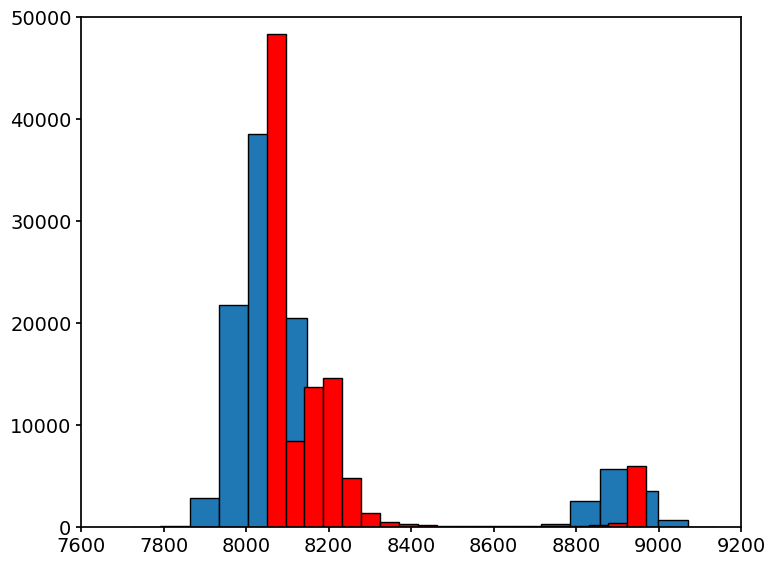

In [28]:
plt.hist(recon_energies, 20)
plt.hist(predicted_data_e, 20, color='red')

The distribution looks reasonable but the peaks looks biased. For reducing the bias, we perform some more training epochs with the same model.

In [10]:
# Creating the FFNN model for hit position reconstruction

# define NN model, compile and train
model_xy = Sequential([
                    Input(shape=(7,3)),
                    Flatten(),
                    BatchNormalization(),
                    Dense(64, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(2, activation='linear')
                    ])

model_xy.compile(optimizer='adam',
                  loss='MSE',
                  metrics=['accuracy'])

model_xy.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21)             │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,430 (239.96 KB)

 Trainable params: 61,388 (239.80 KB)

 Non-trainable params: 42 (168.00 B)

In [11]:
# Defining the path and directory for checkpoints that save the model's weights.
checkpoint_path_xy = "training_1/cp_xy.weights.h5"
checkpoint_dir_xy = os.path.dirname(checkpoint_path_xy)

# Create a callback that saves the model's weights
cp_callback_xy = ModelCheckpoint(filepath=checkpoint_path_xy, save_weights_only=True, verbose=1)

#Training the NN for hit position regression
history_xy = model_xy.fit(input_data, target_data[:,1:], validation_split=0.05, epochs=20, callbacks=[cp_callback_xy])

Epoch 1/20
29649/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.7952 - loss: 4.7962e-06
Epoch 1: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 27s 883us/step - accuracy: 0.7952 - loss: 4.7910e-06 - val_accuracy: 0.8258 - val_loss: 3.4628e-07
Epoch 2/20
29662/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.8328 - loss: 3.6877e-07
Epoch 2: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 26s 874us/step - accuracy: 0.8328 - loss: 3.6876e-07 - val_accuracy: 0.8712 - val_loss: 2.6620e-07
Epoch 3/20
29665/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.8352 - loss: 3.5742e-07
Epoch 3: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 26s 881us/step - accuracy: 0.8352 - loss: 3.5742e-07 - val_accuracy: 0.8374 - val_loss: 2.9396e-07
Epoch 4/20
29680/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.8361 - loss: 3.5399e-07
Epoch 4: saving model to training_1/cp_xy.weights.h5
29688/29

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


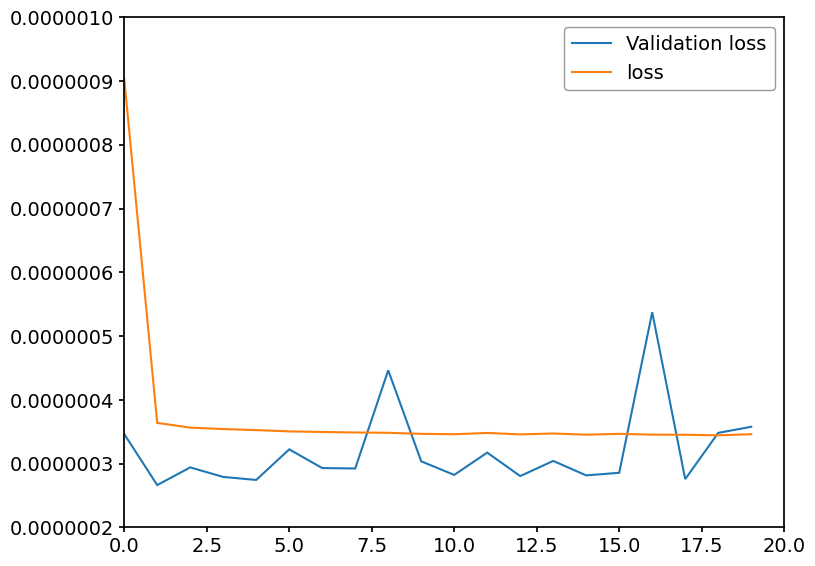

In [12]:
print(history_xy.history.keys())
plt.plot(history_xy.history['val_loss'], label='Validation loss')
plt.plot(history_xy.history['loss'], label='loss')
plt.legend()
plt.show()

In [17]:
# Opening the reconstructed file relative to the test data
test_file = Xraydata('/Users/chiara/hexsampledata/hxsim_20ENC_01srcsigma_test.h5')

>>> Opening input file /Users/chiara/hexsampledata/hxsim_20ENC_01srcsigma_test.h5...
>>> File type: FileType.DIGI


In [26]:
recon_file = ReconInputFile('/Users/chiara/hexsampledata/hxsim_20ENC_01srcsigma_test_recon.h5')

>>> Opening input file /Users/chiara/hexsampledata/hxsim_20ENC_01srcsigma_test_recon.h5...
>>> File type: FileType.RECON


In [27]:
# Obtaining the reconstructed energy
recon_energies = recon_file.column('energy')
recon_x = recon_file.column('posx')
recon_y = recon_file.column('posy')

In [18]:
x_max, y_max = test_file.highest_pixel_coordinates()


In [20]:
test_input_data = test_file.input_events_data()
test_target_data = test_file.target_data()

1000000it [00:34, 28819.79it/s]


In [21]:
predicted_data_xy = model_xy.predict(test_input_data)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 11s 355us/step


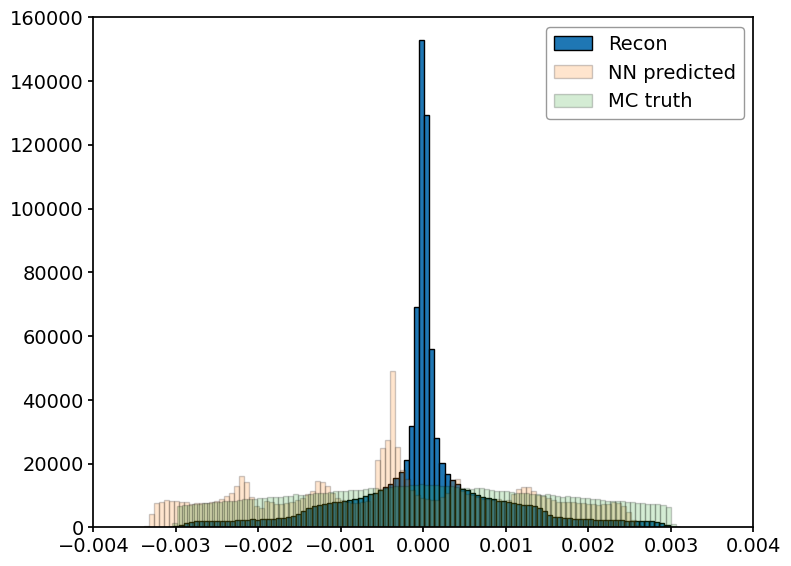

In [30]:
# Plotting the x position distribution and the relative recon
plt.figure()
plt.hist(recon_x - x_max, 100, label='Recon')
plt.hist(predicted_data_xy[:,0], 100, alpha=0.2, label='NN predicted')
plt.hist(test_target_data[:,1], 100, alpha=0.2, label='MC truth')

plt.legend()

(array([4.0000e+00, 1.1000e+01, 8.9000e+01, 3.6800e+02, 1.0710e+03,
        2.9170e+03, 6.3870e+03, 1.0850e+04, 1.5221e+04, 1.7768e+04,
        1.6872e+04, 1.3103e+04, 8.3070e+03, 4.3720e+03, 1.7940e+03,
        6.2600e+02, 1.8500e+02, 4.8000e+01, 5.0000e+00, 2.0000e+00]),
 array([-0.08826511, -0.07920186, -0.07013862, -0.06107538, -0.05201214,
        -0.04294889, -0.03388565, -0.02482241, -0.01575917, -0.00669592,
         0.00236732,  0.01143056,  0.0204938 ,  0.02955705,  0.03862029,
         0.04768353,  0.05674677,  0.06581002,  0.07487325,  0.0839365 ,
         0.09299974], dtype=float32),
 <BarContainer object of 20 artists>)

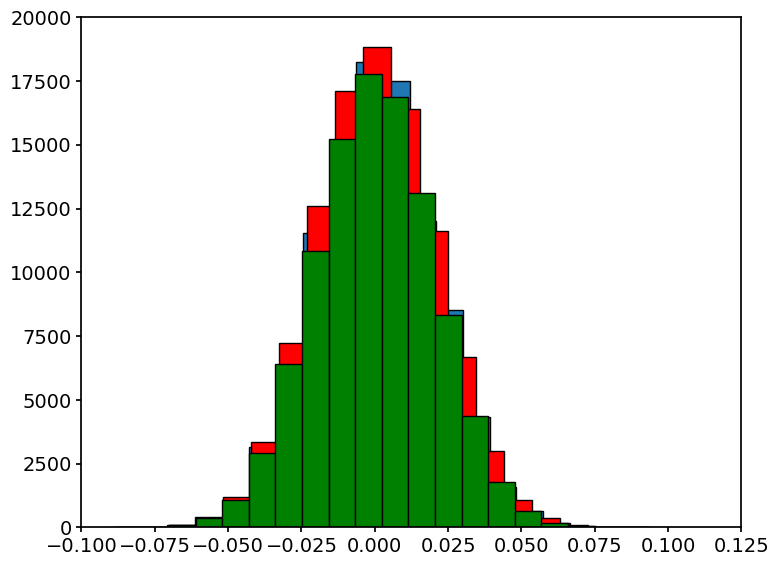

In [61]:
plt.hist(recon_x, 20)
plt.hist(predicted_data_xy[:,0], 20, color='red')
plt.hist(test_target_data[:,1], 20, color='green')

This makes sense to me. Energy and position have two completely different distributions and weights and so the best thing to do is having two different NN. 

In [50]:
test_target_data[:,1] #those are the x

array([-0.00071126, -0.00862364,  0.00348964, ...,  0.00208249,
        0.00677484,  0.00246153], dtype=float32)

In [51]:
print(predicted_data_xy[:,0]) #predicted x

[-0.00130544 -0.00858564  0.00388569 ...  0.00136589  0.00742238
  0.00346861]


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00,
        2.0000e+00, 3.0000e+00, 8.0000e+00, 1.8000e+01, 3.4000e+01,
        4.0000e+01, 8.5000e+01, 1.2100e+02, 2.1200e+02, 3.5100e+02,
        5.8300e+02, 1.2530e+03, 2.5820e+03, 6.1100e+03, 1.2298e+04,
        1.7606e+04, 1.7932e+04, 1.5113e+04, 1.1059e+04, 7.4940e+03,
        4.0650e+03, 1.7310e+03, 7.4600e+02, 2.8400e+02, 1.1800e+02,
        6.9000e+01, 3.6000e+01, 1.7000e+01, 1.0000e+01, 7.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-9.0827793e-03, -8.7331263e-03, -8.3834734e-03, -8.0338214e-03,
        -7.6841684e-03, -7.3345155e-03, -6.9848625e-03, -6.6352100e-03,
        -6.2855571e-03, -5.9359046e-03, -5.5862516e-03, -5.2365987e-03,
        -4.8869462e-03, -4.5372932e-03, -4.1876407e-03, -3.8379878e-03,
        -3.4883351e-03, -3.138

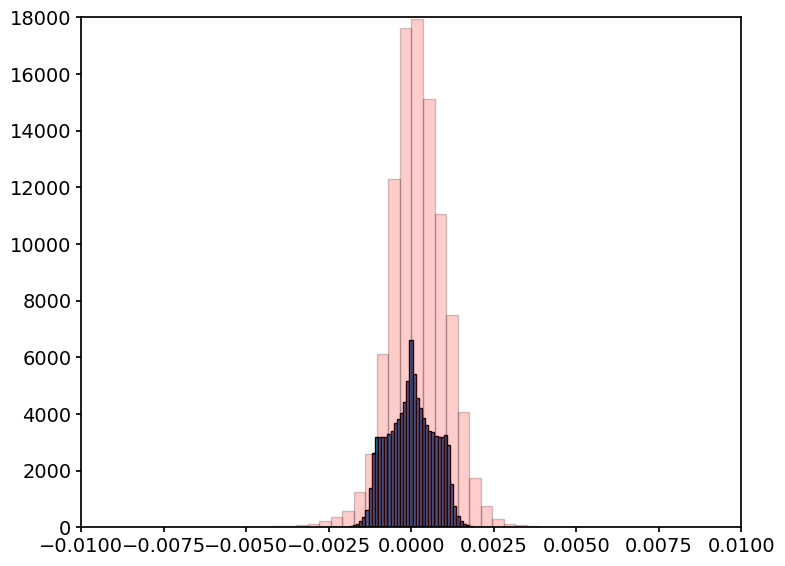

In [56]:
plt.hist(recon_x-test_target_data[:,1], 50)
plt.hist(predicted_data_xy[:,0]-test_target_data[:,1], 50, color='red', alpha=0.2)

(array([3.0000e+00, 2.2000e+01, 8.7000e+01, 3.7800e+02, 1.2490e+03,
        3.1140e+03, 6.8260e+03, 1.1638e+04, 1.5814e+04, 1.8126e+04,
        1.6718e+04, 1.2597e+04, 7.6310e+03, 3.7410e+03, 1.4170e+03,
        4.6100e+02, 1.4600e+02, 2.6000e+01, 5.0000e+00, 1.0000e+00]),
 array([-0.08836965, -0.0791704 , -0.06997115, -0.0607719 , -0.05157265,
        -0.0423734 , -0.03317416, -0.02397491, -0.01477566, -0.00557641,
         0.00362284,  0.01282209,  0.02202133,  0.03122058,  0.04041983,
         0.04961908,  0.05881833,  0.06801757,  0.07721683,  0.08641607,
         0.09561532], dtype=float32),
 <BarContainer object of 20 artists>)

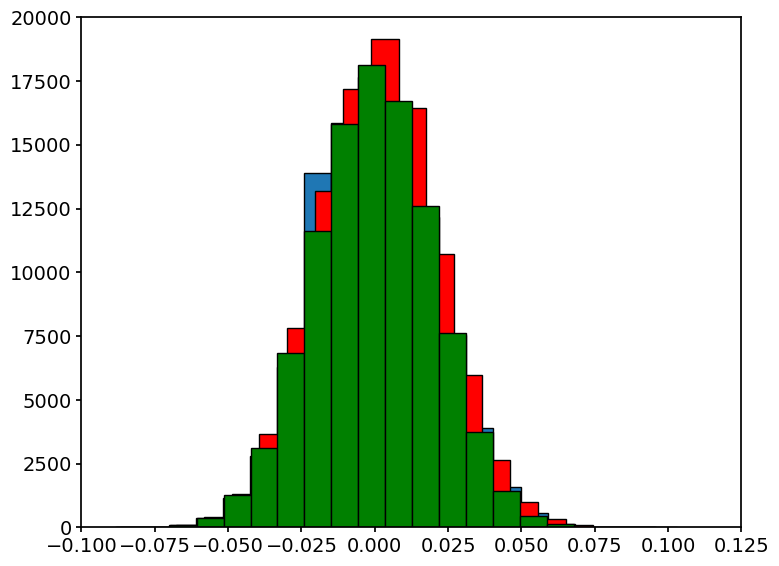

In [60]:
plt.hist(recon_y, 20)
plt.hist(predicted_data_xy[:,1], 20, color='red')
plt.hist(test_target_data[:,2], 20, color='green')

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 1.3000e+01, 2.2000e+01,
        5.0000e+01, 7.2000e+01, 2.1400e+02, 3.7700e+02, 8.5900e+02,
        1.6780e+03, 3.2650e+03, 6.5010e+03, 1.0327e+04, 1.3215e+04,
        1.4101e+04, 1.3199e+04, 1.1080e+04, 8.6940e+03, 5.8670e+03,
        3.6310e+03, 2.2620e+03, 1.4730e+03, 9.6800e+02, 6.4500e+02,
        4.5400e+02, 3.2000e+02, 2.0700e+02, 1.6400e+02, 1.0700e+02,
        6.4000e+01, 5.6000e+01, 4.3000e+01, 1.8000e+01, 1.9000e+01,
        1.3000e+01, 6.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-2.5283382e-03, -2.3214587e-03, -2.1145791e-03, -1.9076995e-03,
        -1.7008201e-03, -1.4939405e-03, -1.2870609e-03, -1.0801813e-03,
        -8.7330182e-04, -6.6642225e-04, -4.5954267e-04, -2.5266313e-04,
        -4.5783574e-05,  1.6109597e-04,  3.6797553e-04,  5.7485508e-04,
         7.8173465e-04,  9.886

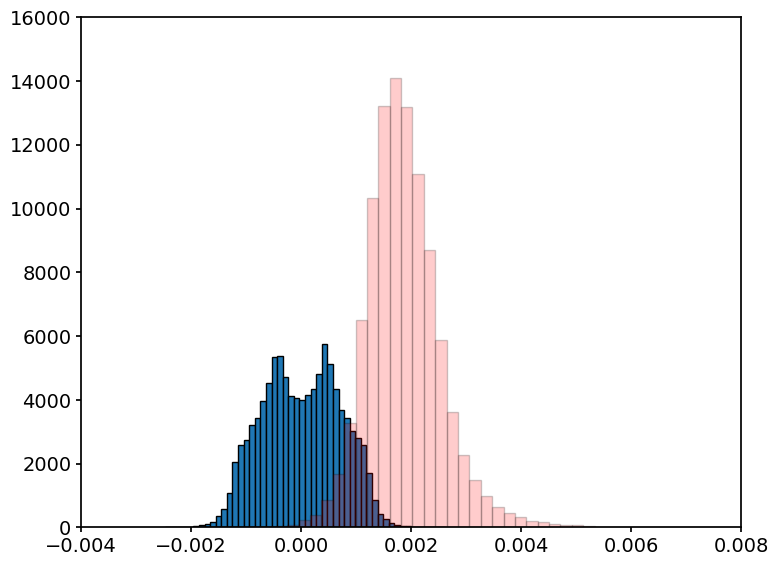

In [58]:
plt.hist(recon_y-test_target_data[:,2], 50)
plt.hist(predicted_data_xy[:,1]-test_target_data[:,2], 50, color='red', alpha=0.2)

The y distribution is biased of 2 micrometers circa. The bias in a NN can be diminished with training. Let's try to train for more epochs.

In [63]:
#Training the NN for hit position regression
history_xy = model_xy.fit(input_data, target_data[:,1:], validation_split=0.05, epochs=50, callbacks=[cp_callback_xy])

Epoch 1/50
29632/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.9378 - loss: 1.6324e-05
Epoch 1: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 26s 870us/step - accuracy: 0.9378 - loss: 1.6323e-05 - val_accuracy: 0.9751 - val_loss: 2.0887e-06
Epoch 2/50
29643/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.9379 - loss: 1.6343e-05
Epoch 2: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 24s 816us/step - accuracy: 0.9379 - loss: 1.6343e-05 - val_accuracy: 0.9884 - val_loss: 7.0664e-07
Epoch 3/50
29665/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.9376 - loss: 1.6301e-05
Epoch 3: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 25s 844us/step - accuracy: 0.9376 - loss: 1.6301e-05 - val_accuracy: 0.9830 - val_loss: 1.4232e-06
Epoch 4/50
29640/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.9379 - loss: 1.6180e-05
Epoch 4: saving model to training_1/cp_xy.weights.h5
29688/29

In [64]:
predicted_data_xy = model_xy.predict(test_input_data)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 370us/step


(array([2.0000e+00, 1.0000e+00, 3.0000e+00, 4.0000e+00, 3.0000e+00,
        8.0000e+00, 7.0000e+00, 1.0000e+01, 7.0000e+00, 2.0000e+01,
        3.1000e+01, 4.8000e+01, 5.7000e+01, 6.1000e+01, 1.2200e+02,
        1.6200e+02, 3.2600e+02, 5.9100e+02, 1.0650e+03, 1.7910e+03,
        2.8690e+03, 4.8190e+03, 6.9580e+03, 8.9870e+03, 9.9850e+03,
        1.0331e+04, 1.0160e+04, 9.7660e+03, 8.6660e+03, 7.5010e+03,
        5.6910e+03, 3.8830e+03, 2.5440e+03, 1.5180e+03, 8.7800e+02,
        5.2100e+02, 2.7500e+02, 1.5200e+02, 8.4000e+01, 5.2000e+01,
        1.4000e+01, 1.6000e+01, 5.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-4.1408837e-03, -3.9617652e-03, -3.7826470e-03, -3.6035285e-03,
        -3.4244102e-03, -3.2452918e-03, -3.0661735e-03, -2.8870550e-03,
        -2.7079368e-03, -2.5288183e-03, -2.3497001e-03, -2.1705816e-03,
        -1.9914634e-03, -1.8123449e-03, -1.6332265e-03, -1.4541082e-03,
        -1.2749898e-03, -1.095

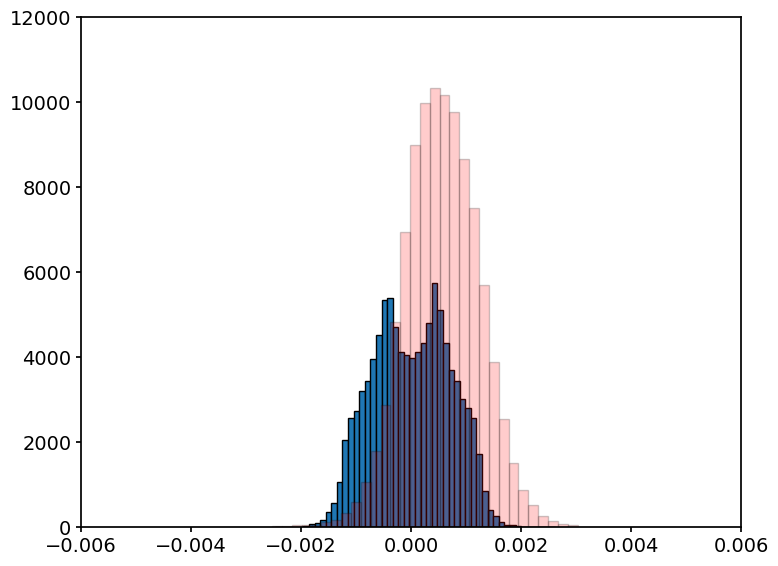

In [65]:
plt.hist(recon_y-test_target_data[:,2], 50)
plt.hist(predicted_data_xy[:,1]-test_target_data[:,2], 50, color='red', alpha=0.2)

As we can see, bias is getting thinner, let's do another 50 epochs.

In [66]:
#Training the NN for hit position regression
history_xy = model_xy.fit(input_data, target_data[:,1:], validation_split=0.05, epochs=50, callbacks=[cp_callback_xy])

Epoch 1/50
29649/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.9380 - loss: 1.6052e-05
Epoch 1: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 25s 831us/step - accuracy: 0.9380 - loss: 1.6052e-05 - val_accuracy: 0.9830 - val_loss: 1.4754e-06
Epoch 2/50
29633/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.9373 - loss: 1.6152e-05
Epoch 2: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 24s 813us/step - accuracy: 0.9373 - loss: 1.6152e-05 - val_accuracy: 0.9515 - val_loss: 5.2441e-06
Epoch 3/50
29667/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.9372 - loss: 1.6050e-05
Epoch 3: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 25s 826us/step - accuracy: 0.9372 - loss: 1.6050e-05 - val_accuracy: 0.9863 - val_loss: 1.8474e-06
Epoch 4/50
29678/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.9375 - loss: 1.6108e-05
Epoch 4: saving model to training_1/cp_xy.weights.h5
29688/29

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


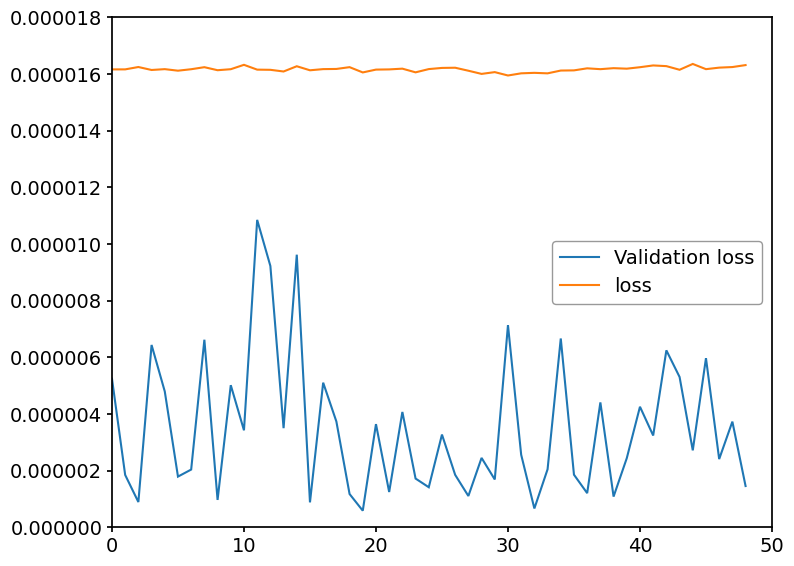

In [69]:
print(history_xy.history.keys())
plt.plot(history_xy.history['val_loss'][1:], label='Validation loss')
plt.plot(history_xy.history['loss'][1:], label='loss')
plt.legend()
plt.show()

In [67]:
predicted_data_xy = model_xy.predict(test_input_data)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step


(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 3.0000e+00,
        6.0000e+00, 2.2000e+01, 4.4000e+01, 7.9000e+01, 2.1300e+02,
        5.5300e+02, 1.3090e+03, 2.6050e+03, 4.7710e+03, 8.0730e+03,
        1.2152e+04, 1.4553e+04, 1.4650e+04, 1.2970e+04, 9.2570e+03,
        7.0870e+03, 5.1340e+03, 2.7360e+03, 1.5730e+03, 9.8000e+02,
        5.4700e+02, 2.9200e+02, 1.4600e+02, 8.0000e+01, 5.5000e+01,
        3.8000e+01, 3.2000e+01, 1.2000e+01, 5.0000e+00, 5.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-4.8975931e-03, -4.6383347e-03, -4.3790764e-03, -4.1198181e-03,
        -3.8605598e-03, -3.6013012e-03, -3.3420429e-03, -3.0827846e-03,
        -2.8235263e-03, -2.5642680e-03, -2.3050096e-03, -2.0457513e-03,
        -1.7864929e-03, -1.5272346e-03, -1.2679762e-03, -1.0087178e-03,
        -7.4945949e-04, -4.902

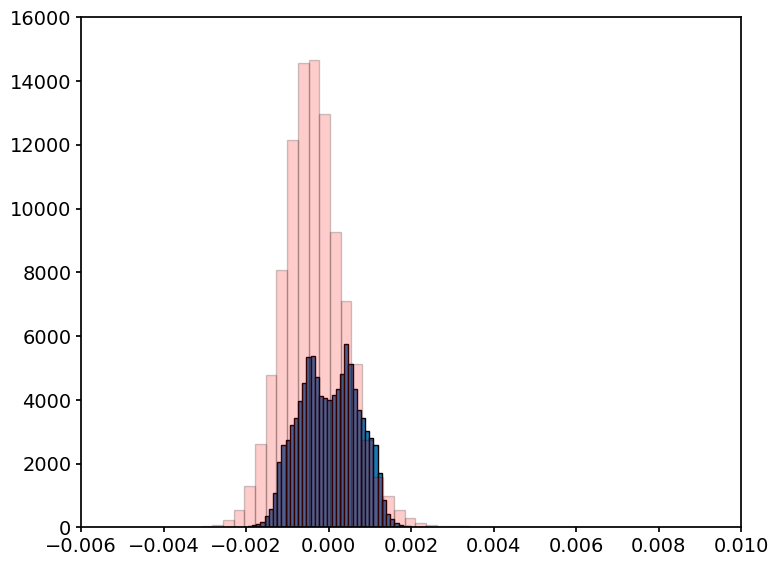

In [68]:
plt.hist(recon_y-test_target_data[:,2], 50)
plt.hist(predicted_data_xy[:,1]-test_target_data[:,2], 50, color='red', alpha=0.2)

It is possible to notice that the bias changed (and in particular dimished) as the epochs increased but the variance remained the same, because the model complexity didn't change. 
Let's try to change the model with a more complex one and do the same number of epochs (that is 120, bc is the sum of the precedent ones).

In [39]:
# Creating the FFNN model for hit position reconstruction

# define NN model, compile and train
model_xy2 = Sequential([
                    Input(shape=(7,3)),
                    Flatten(),
                    BatchNormalization(),
                    Dense(64, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(2, activation='linear')
                    ])

model_xy2.compile(optimizer='adam',
                  loss='MSE',
                  metrics=['accuracy'])

model_xy2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21)             │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,630 (338.40 KB)

 Trainable params: 86,588 (338.23 KB)

 Non-trainable params: 42 (168.00 B)

In [58]:
# Loading the last model weights if already trained at least once
checkpoint_path = "training_2/cp_xy2.weights.h5"
model_xy2.load_weights(checkpoint_path)

/opt/homebrew/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [73]:
# Defining the path and directory for checkpoints that save the model's weights.
checkpoint_path_xy2 = "training_2/cp_xy2.weights.h5"
checkpoint_dir_xy2 = os.path.dirname(checkpoint_path_xy2)

# Create a callback that saves the model's weights
cp_callback_xy2 = ModelCheckpoint(filepath=checkpoint_path_xy2, save_weights_only=True, verbose=1)

#Training the NN for hit position regression
history_xy2 = model_xy2.fit(input_data, target_data[:,1:], validation_split=0.05, epochs=120, callbacks=[cp_callback_xy2])

Epoch 1/120
29643/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9278 - loss: 2.6562e-05
Epoch 1: saving model to training_2/cp_xy2.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - accuracy: 0.9278 - loss: 2.6552e-05 - val_accuracy: 0.9670 - val_loss: 3.5354e-06
Epoch 2/120
29687/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9353 - loss: 1.7420e-05
Epoch 2: saving model to training_2/cp_xy2.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - accuracy: 0.9353 - loss: 1.7420e-05 - val_accuracy: 0.9522 - val_loss: 7.4369e-06
Epoch 3/120
29656/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9368 - loss: 1.6398e-05
Epoch 3: saving model to training_2/cp_xy2.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step - accuracy: 0.9368 - loss: 1.6398e-05 - val_accuracy: 0.9103 - val_loss: 1.2767e-05
Epoch 4/120
29655/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9362 - loss: 1.6595e-05
Epoch 4: saving model to training_2/cp_xy2.weights.h5
29688/29688 ━━

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


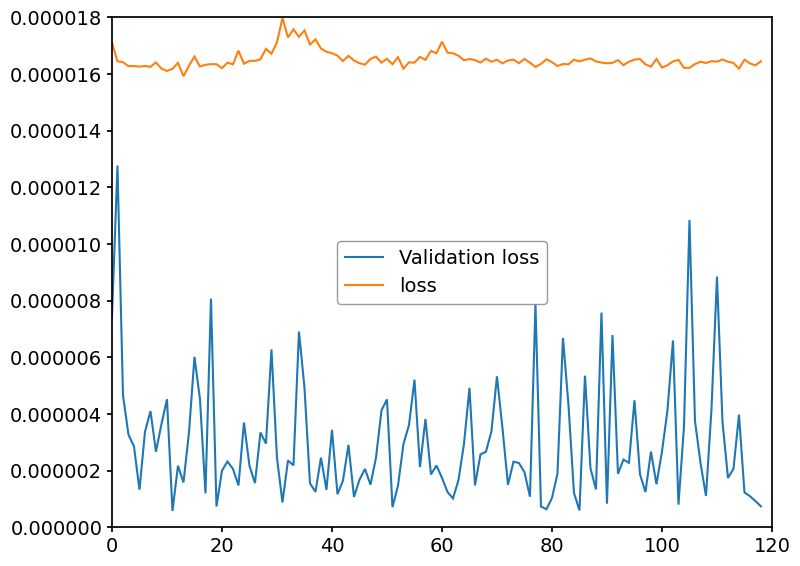

In [74]:
print(history_xy2.history.keys())
plt.plot(history_xy2.history['val_loss'][1:], label='Validation loss')
plt.plot(history_xy2.history['loss'][1:], label='loss')
plt.legend()
plt.show()

In [79]:
predicted_data_xy2 = model_xy2.predict(test_input_data)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 2.0000e+00, 5.0000e+00, 4.0000e+00, 5.0000e+00,
        1.1000e+01, 2.5000e+01, 5.4000e+01, 7.1000e+01, 1.3200e+02,
        3.0600e+02, 1.0060e+03, 2.3750e+03, 4.8480e+03, 8.7020e+03,
        1.3799e+04, 1.8070e+04, 1.7252e+04, 1.3508e+04, 8.7280e+03,
        5.2980e+03, 2.8690e+03, 1.3940e+03, 6.5900e+02, 3.7500e+02,
        2.1400e+02, 9.0000e+01, 6.8000e+01, 4.7000e+01, 3.2000e+01,
        1.2000e+01, 1.3000e+01, 2.0000e+00, 6.0000e+00, 3.0000e+00,
        3.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-5.3336173e-03, -5.0677927e-03, -4.8019681e-03, -4.5361435e-03,
        -4.2703189e-03, -4.0044943e-03, -3.7386694e-03, -3.4728448e-03,
        -3.2070202e-03, -2.9411956e-03, -2.6753708e-03, -2.4095462e-03,
        -2.1437216e-03, -1.8778970e-03, -1.6120723e-03, -1.3462476e-03,
        -1.0804230e-03, -8.145

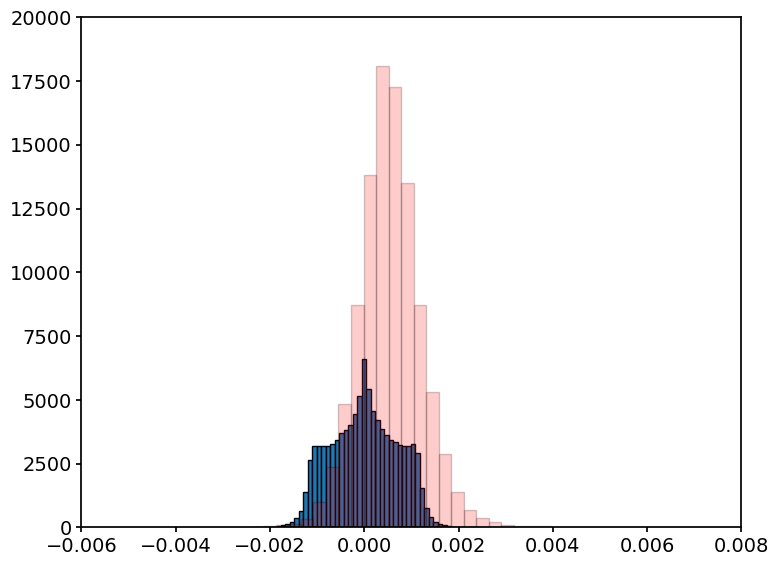

In [80]:
plt.hist(recon_x-test_target_data[:,1], 50)
plt.hist(predicted_data_xy2[:,0]-test_target_data[:,1], 50, color='red', alpha=0.2)

The x seems a little biased, needs more epochs. 
**TO DO**
- The NN reco looks gaussian, so the resolution can be computed as its sigma, fit and compute it [];
- the standard reconstruction is not gaussian in both x and y so I should choose another metric, for example for the x half the width of this strange distribution and for the y the distance between the two peaks [].

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 6.0000e+00, 6.0000e+00, 6.0000e+00,
        1.4000e+01, 1.6000e+01, 3.5000e+01, 5.2000e+01, 8.0000e+01,
        1.2300e+02, 2.6800e+02, 4.3900e+02, 8.3500e+02, 1.6110e+03,
        3.1760e+03, 5.9080e+03, 9.9250e+03, 1.5463e+04, 1.8606e+04,
        1.6062e+04, 1.1932e+04, 7.8390e+03, 4.3070e+03, 1.8230e+03,
        7.7600e+02, 3.1800e+02, 1.5100e+02, 8.6000e+01, 5.1000e+01,
        2.8000e+01, 9.0000e+00, 1.2000e+01, 1.3000e+01, 6.0000e+00,
        5.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-6.8754703e-03, -6.6113845e-03, -6.3472982e-03, -6.0832123e-03,
        -5.8191265e-03, -5.5550402e-03, -5.2909544e-03, -5.0268685e-03,
        -4.7627822e-03, -4.4986964e-03, -4.2346106e-03, -3.9705243e-03,
        -3.7064385e-03, -3.4423526e-03, -3.1782666e-03, -2.9141805e-03,
        -2.6500947e-03, -2.386

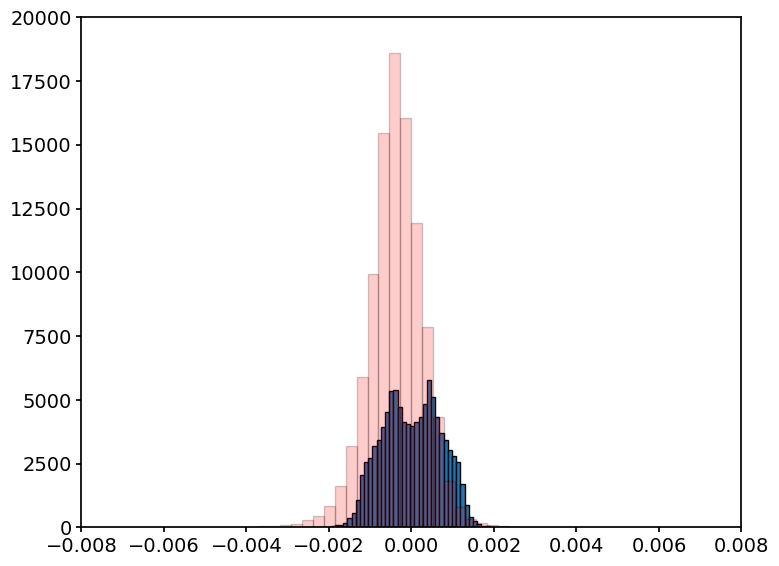

In [81]:
plt.hist(recon_y-test_target_data[:,2], 50)
plt.hist(predicted_data_xy2[:,1]-test_target_data[:,2], 50, color='red', alpha=0.2)

Didn't really change... maybe more and more params but anyway the NN wrt the classical reconstruction does not suffer of asymmetry due to the disposition of the pixels (indeed the NN does not know anything about the hexagonal grid...). 

Per prova, vediamo che fa sui dati con il rumore

In [29]:
noisy_dataset_20_enc = Xraydata('/Users/chiara/hexsampledata/sim_HexagonalLayout.ODD_Rum_20enc_srcsigma200um.h5')


>>> Opening input file /Users/chiara/hexsampledata/sim_HexagonalLayout.ODD_Rum_20enc_srcsigma200um.h5...
>>> File type: FileType.DIGI


In [30]:
# The Xraydata object contains methods for preprocessing that give the input and training output for the NN
noisy_input_data = noisy_dataset_20_enc.input_events_data()
# Obtaining training output data from MC truth
noisy_target_data = noisy_dataset_20_enc.target_data()

100000it [00:03, 27052.51it/s]


In [54]:
# Checking if it is easy to append different datasets.
full_input_dataset = np.append(input_data, noisy_input_data, axis=0)

In [56]:
print(full_input_dataset)
print(full_input_dataset.shape)


[[[ 2.18500000e+03  2.25000000e-02 -7.79422863e-03]
  [ 0.00000000e+00  2.55000000e-02 -2.59807621e-03]
  [ 0.00000000e+00  2.85000000e-02 -7.79422863e-03]
  ...
  [ 0.00000000e+00  1.95000000e-02 -1.29903811e-02]
  [ 0.00000000e+00  1.65000000e-02 -7.79422863e-03]
  [ 0.00000000e+00  1.95000000e-02 -2.59807621e-03]]

 [[ 1.48000000e+03 -4.50000000e-03  1.81865335e-02]
  [ 6.99000000e+02 -1.50000000e-03  2.33826859e-02]
  [ 0.00000000e+00  1.50000000e-03  1.81865335e-02]
  ...
  [ 0.00000000e+00 -7.50000000e-03  1.29903811e-02]
  [ 0.00000000e+00 -1.05000000e-02  1.81865335e-02]
  [ 0.00000000e+00 -7.50000000e-03  2.33826859e-02]]

 [[ 2.12900000e+03 -4.50000000e-03 -2.59807621e-03]
  [ 0.00000000e+00 -1.50000000e-03  2.59807621e-03]
  [ 0.00000000e+00  1.50000000e-03 -2.59807621e-03]
  ...
  [ 5.00000000e+01 -7.50000000e-03 -7.79422863e-03]
  [ 1.00000000e+01 -1.05000000e-02 -2.59807621e-03]
  [ 0.00000000e+00 -7.50000000e-03  2.59807621e-03]]

 ...

 [[ 2.10700000e+03  3.75000000e-03

In [32]:
# Opening the reconstructed file relative to the test data
recon_file = ReconInputFile('/Users/chiara/hexsampledata/sim_HexagonalLayout.ODD_Rum_20enc_srcsigma200um_recon.h5')

>>> Opening input file /Users/chiara/hexsampledata/sim_HexagonalLayout.ODD_Rum_20enc_srcsigma200um_recon.h5...
>>> File type: FileType.RECON


In [ ]:
# Trying to append two files


In [36]:
recon_noisy_energies = recon_file.column('energy')
recon_noisy_x = recon_file.column('posx')
recon_noisy_y = recon_file.column('posy')

In [43]:
# Trying to predict the energy
predicted_noisy_e = model_e.predict(noisy_input_data)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 370us/step


In [42]:
# Trying to predict the hit coordinates
predicted_noisy_xy = model_xy2.predict(noisy_input_data)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step


(array([32636.,  7577., 12304., 17105., 10930.,  3607.,  1523.,  1097.,
          820.,   621.,   510.,   512.,   473.,   473.,   397.,   399.,
          370.,   571.,  1230.,  6845.]),
 array([8050.709 , 8096.5894, 8142.47  , 8188.3506, 8234.231 , 8280.111 ,
        8325.992 , 8371.873 , 8417.754 , 8463.634 , 8509.515 , 8555.3955,
        8601.275 , 8647.156 , 8693.037 , 8738.918 , 8784.798 , 8830.679 ,
        8876.56  , 8922.439 , 8968.32  ], dtype=float32),
 <BarContainer object of 20 artists>)

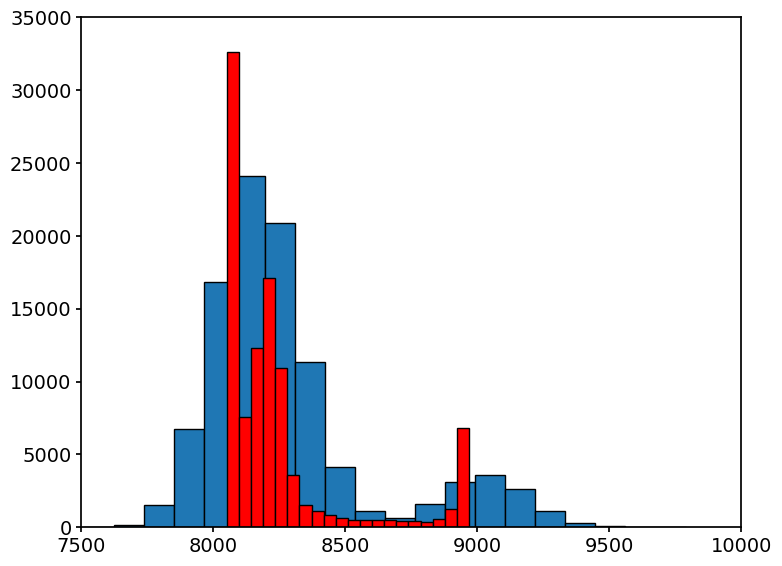

In [35]:
plt.hist(recon_noisy_energies, 20)
plt.hist(predicted_noisy_e, 20, color='red')

Actually not bad I guess. Let's see the positions.

(array([2.0000e+00, 9.0000e+00, 4.6000e+01, 2.1800e+02, 7.5300e+02,
        2.0600e+03, 5.0790e+03, 9.6040e+03, 1.4673e+04, 1.8807e+04,
        1.8606e+04, 1.4389e+04, 8.8870e+03, 4.2350e+03, 1.8110e+03,
        5.4300e+02, 2.0900e+02, 5.5000e+01, 1.0000e+01, 4.0000e+00]),
 array([-0.09473774, -0.0851453 , -0.07555287, -0.06596044, -0.056368  ,
        -0.04677557, -0.03718314, -0.0275907 , -0.01799827, -0.00840583,
         0.0011866 ,  0.01077904,  0.02037147,  0.0299639 ,  0.03955634,
         0.04914877,  0.0587412 ,  0.06833364,  0.07792608,  0.08751851,
         0.09711094], dtype=float32),
 <BarContainer object of 20 artists>)

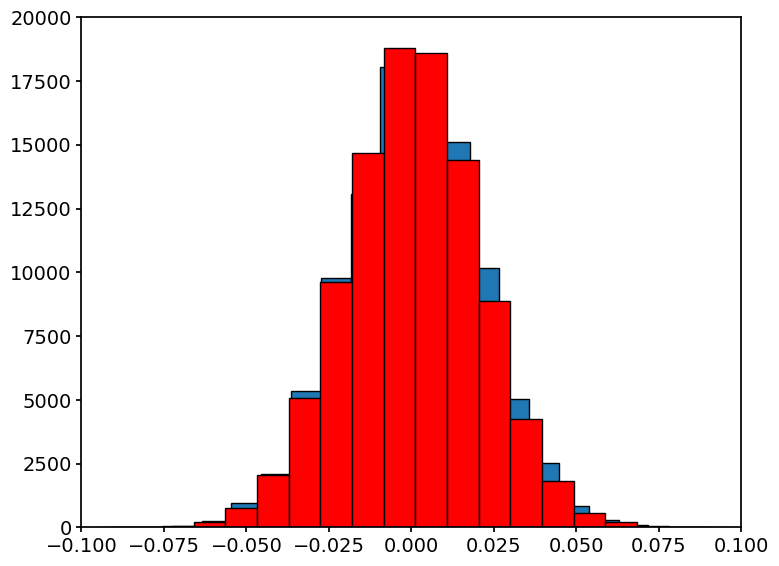

In [48]:
plt.hist(recon_noisy_x, 20)
plt.hist(predicted_noisy_xy[:,0], 20, color='red')

(array([1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 4.0000e+00, 3.0000e+00, 1.3000e+01,
        1.8000e+01, 1.7000e+01, 2.8000e+01, 6.6000e+01, 1.0500e+02,
        2.0900e+02, 4.4800e+02, 1.0130e+03, 2.5160e+03, 4.7210e+03,
        8.0700e+03, 1.1546e+04, 1.4375e+04, 1.4885e+04, 1.3214e+04,
        9.9710e+03, 6.7820e+03, 4.5790e+03, 2.9090e+03, 1.8200e+03,
        1.1070e+03, 6.4800e+02, 3.5100e+02, 2.0000e+02, 1.3400e+02,
        7.4000e+01, 3.9000e+01, 3.0000e+01, 3.0000e+01, 2.4000e+01,
        1.3000e+01, 1.0000e+01, 5.0000e+00, 5.0000e+00, 6.0000e+00,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-0.00496732, -0.00473573, -0.00450413, -0.00427253, -0.00404094,
        -0.00380934, -0.00357774, -0.00334615, -0.00311455, -0.00288295,
        -0.00265136, -0.00241976, -0.00218816, -0.00195657, -0.00172497,
        -0.00149337, -0.00126178, -0.00103018, -0.00079858, -0.00056698,
        -0.00033539, -0.00

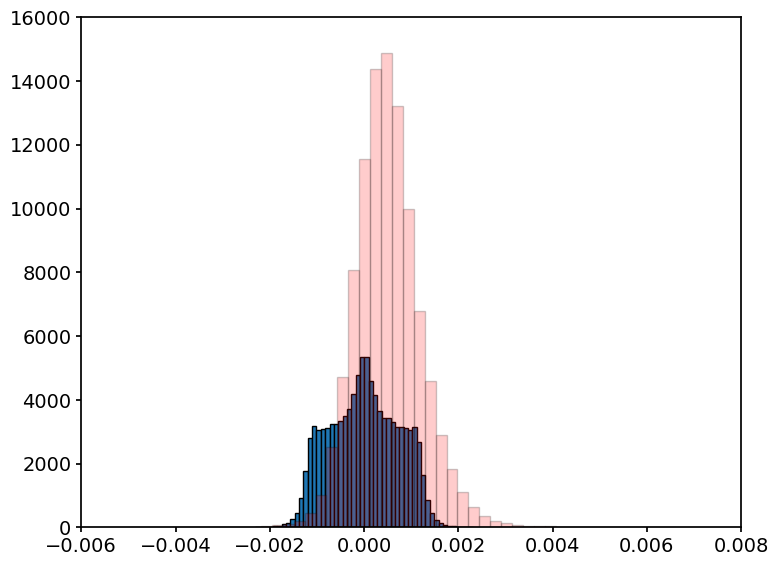

In [49]:
plt.hist(recon_noisy_x-noisy_target_data[:,1], 50)
plt.hist(predicted_noisy_xy[:,0]-noisy_target_data[:,1], 50, color='red', alpha=0.2)

Biased, again, but not so bad.

To do:
- evaluate the mse for both the networks [];
- mix the dataset with noise data (this should provide data augumentation for the network but maybe it is necessary to see the data augumentation theory a little more) [];
- when the NN performances are satisfying, it's time to compare with the reconstructed performances:
    - need to choose the right metrics (even if the squared difference seems the easier and most reasonable choice) [];
    - some plots? []
- when everything works, it would be interesting to test the NN with a simulation having a UNIFORM BEAM, to see if the model just learned the pdf or found an interesting latent space where to represent the phase space.